In [17]:
!pip install statsmodels

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

#from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
warnings.simplefilter(action="ignore", category=FutureWarning)

In [19]:
##host='192.239.162.2'
#client=MongoClient(host=host,port=27017)
##db = client["air-quality"]
#nairobi = db["nairobi"]

In [20]:
#def wrangle(collection):
    #results = collection.find(
       # {"metadata.site": 29, "metadata.measurement": "P2"},
      #  projection={"P2": 1, "timestamp": 1, "_id": 0},
    #)

    # Read data into DataFrame
    #df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
   # df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    #df = df[df["P2"] < 500]

    # Resample to 1hr window
    #y = df["P2"].resample("1H").mean().fillna(method='ffill').to_frame()
    #y = df["P2"].resample("1H").mean().fillna(method='ffill')
    #return y

In [21]:


y = pd.read_csv("data/nairobi_data.csv")
#y = wrangle(df)
y.head()

,P2
0,17.541667
1,15.800000
2,11.420000
3,11.614167
4,17.665000


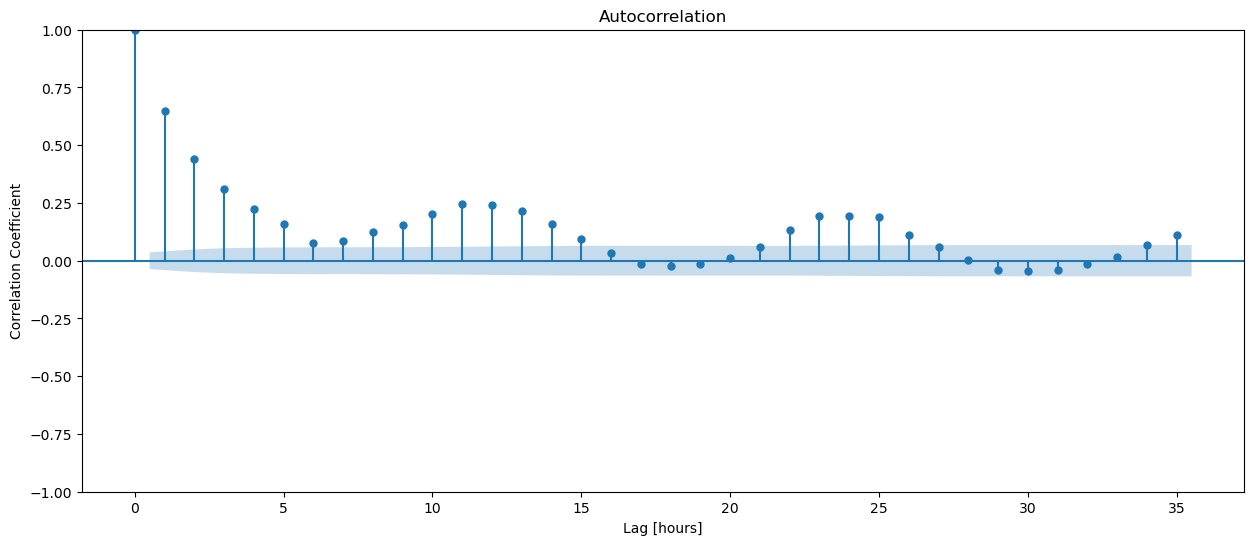

In [22]:
#acf plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

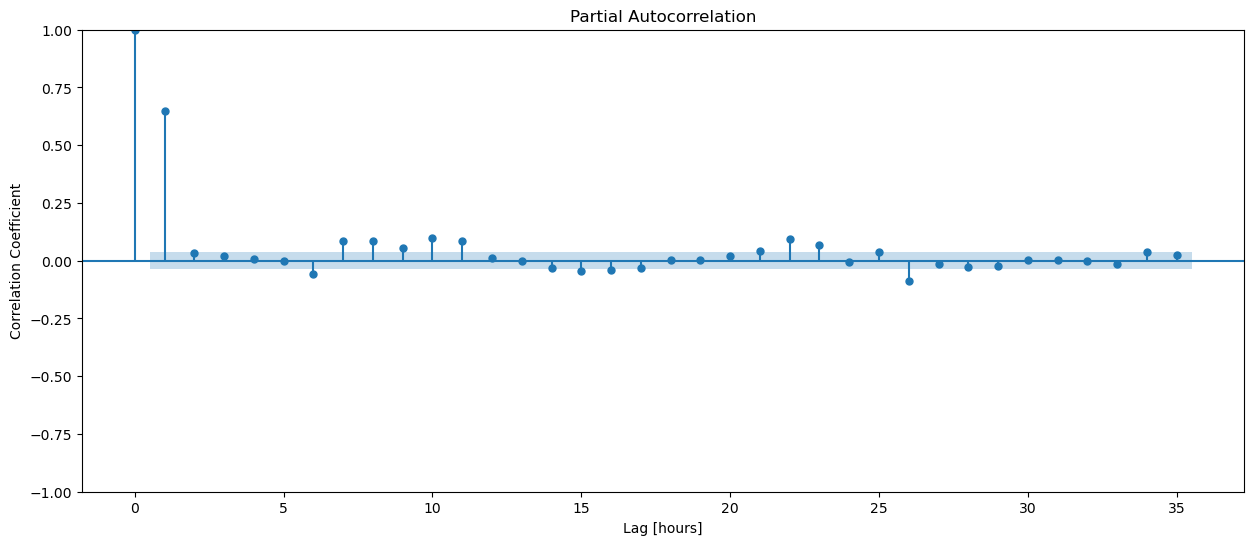

In [23]:
#pacf plot for choosing lag order of PACF
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [24]:
#splitting data




cutoff = int(len(y)*0.95)
y_train =  y.iloc[:cutoff]
y_test =  y.iloc[cutoff:]

In [25]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: P2    9.22
dtype: float64
Baseline MAE: 3.71


In [26]:
#AR model
model = AutoReg(y_train, lags=26).fit()

In [27]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.2809871656467067


In [28]:
y_train_resid =model.resid
y_train_resid.tail()
#y_train_resid = y_train - y_pred

2776   -0.392002
2777   -1.573180
2778   -0.735747
2779   -2.022221
2780   -0.061916
dtype: float64

<Axes: ylabel='residual value'>

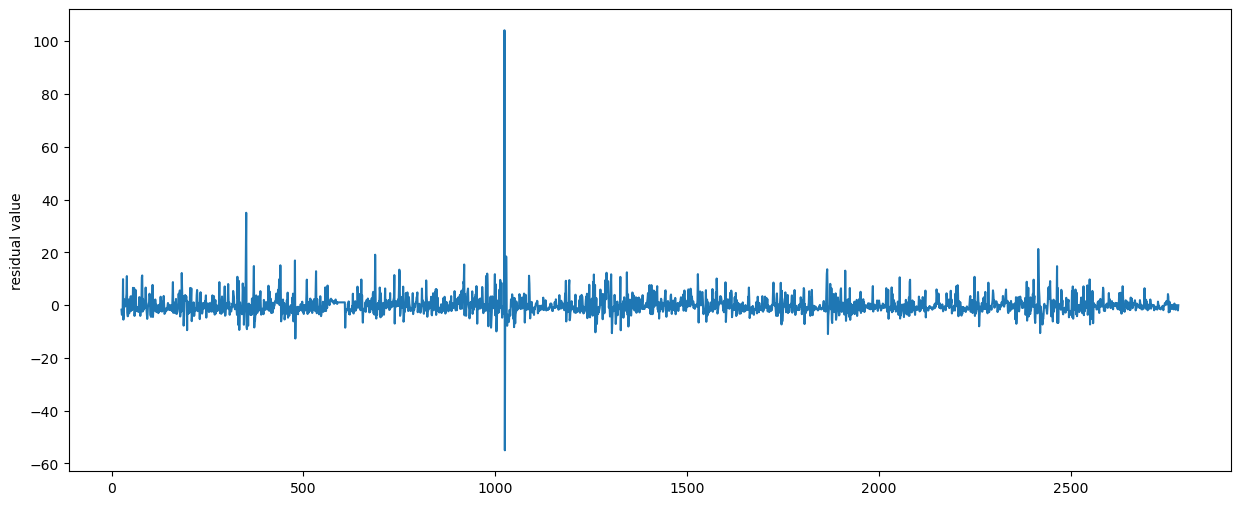

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="residual value",ax=ax)

Text(0.5, 1.0, 'ar(26), Distribution of residuals')

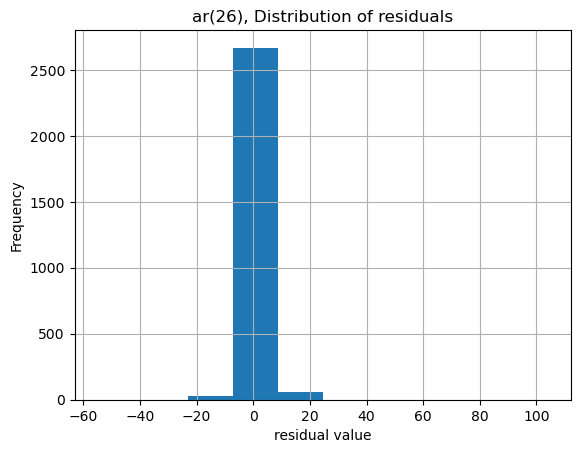

In [30]:
#checking if residual follow noraml distri
y_train_resid.hist()
plt.xlabel("residual value")
plt.ylabel('Frequency')
plt.title("ar(26), Distribution of residuals")

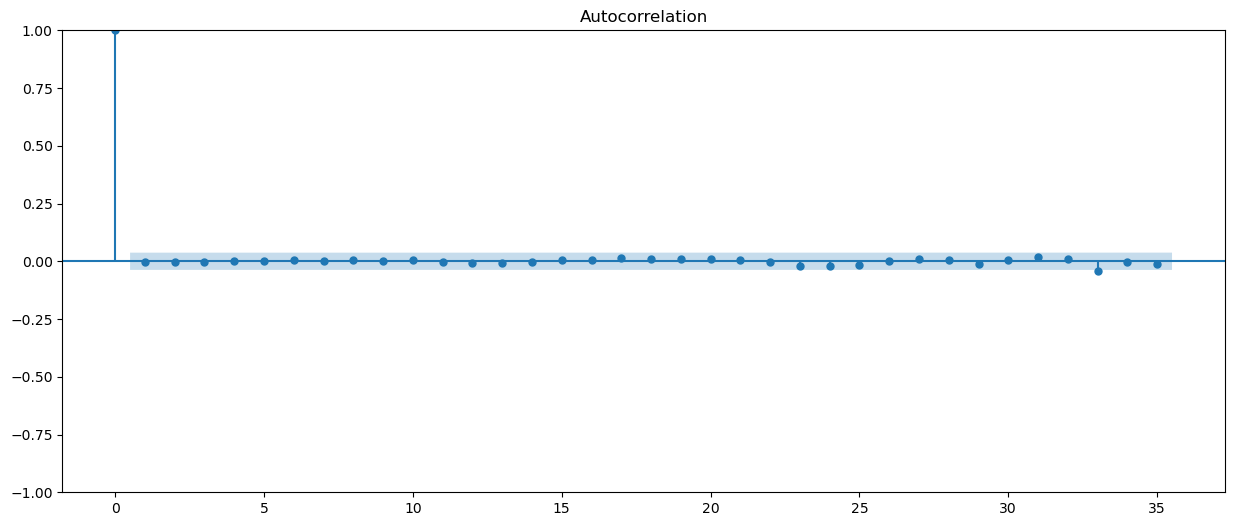

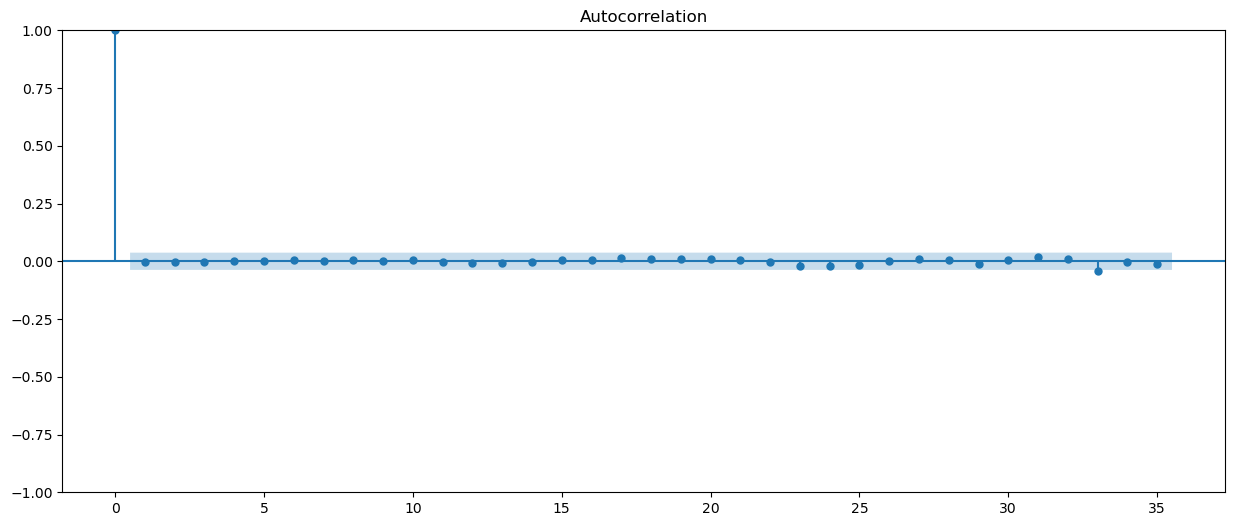

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)

In [32]:
#evaluation
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 3.0136439495039276


In [33]:
#passing a dictionary
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test.squeeze(),       # or y_test.iloc[:, 0]
        "y_pred": y_pred_test.squeeze()   # same here
    },
    index=y_test.index
)



In [34]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

In [35]:
%%capture

# Start with an empty list to collect predictions
predictions_list = []
history = y_train.copy()

for i in range(len(y_test)):
    # Fit the model on the history
    model = AutoReg(history, lags=26).fit()
    
    # Forecast the next step
    next_pred = model.forecast()
    
    # Add the prediction to our list
    predictions_list.append(next_pred)
    
    # Append the actual observed value from the test set to the history
    # We use iloc[[i]] to get the next row from y_test
    history = pd.concat([history, y_test.iloc[[i]]])

# After the loop, create the final Series of predictions all at once
y_pred_wfv = pd.concat(predictions_list)

In [36]:
len(y_pred_wfv)

147

In [37]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.4


In [38]:
print(model.params)


const     2.011432
P2.L1     0.587118
P2.L2     0.019796
P2.L3     0.023615
P2.L4     0.027187
P2.L5     0.044014
P2.L6    -0.102128
P2.L7     0.029583
P2.L8     0.049867
P2.L9    -0.016897
P2.L10    0.032438
P2.L11    0.064360
P2.L12    0.005987
P2.L13    0.018375
P2.L14   -0.007636
P2.L15   -0.016075
P2.L16   -0.015953
P2.L17   -0.035444
P2.L18    0.000756
P2.L19   -0.003907
P2.L20   -0.020655
P2.L21   -0.012578
P2.L22    0.052499
P2.L23    0.074229
P2.L24   -0.023806
P2.L25    0.090577
P2.L26   -0.088323
dtype: float64


In [39]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test.squeeze(), "y_pred_wfv": y_pred_wfv}

)

fig = px.line(df_pred_test, labels={"value":"PM2.5"})
fig.show()